In [1]:
from pyscenic.aucell import aucell
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
path_data = ''
path_fig = ''

In [2]:
adata = sc.read_h5ad(Path(path_data)/"OSMGT_ad_scenic.h5ad")
tst = adata.var
tst.columns=['gene_name']
tst.index = list(tst['gene_name'])
adata.var = tst

In [3]:
selected_cluster = ['CNS Neurons',
 'Diencephalic Progenitors',
 'FOXA2+ Cells',
 'Hindbrain Progenitors',
 'Hypothalamic Progenitors',
 'Neural Crest',
 'PNS Neurons',
 'PNS Progenitors',
 'Retinal Progenitors',
 'Spinal Cord Progenitors',
 'Telencephalic Progenitors']

adata = adata[adata.obs['merged_cluster_annotation'].isin(selected_cluster)].copy()
meta = adata.obs.copy()


In [4]:
file = open(Path(path_data)/"HES3_regulons_42.p",'rb')
object_file = pickle.load(file)
file.close()
modules = object_file.copy

In [5]:
ex_matrix = pd.DataFrame.sparse.from_spmatrix(adata.X)
ex_matrix.index  = adata.obs.index
ex_matrix.columns = adata.var.gene_name.values
ex_matrix.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
AT1_AAACCCACAGTCAACT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1_AAACCCAGTGTAAACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AT1_AAACCCATCCGCGAGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1_AAACGAAAGTAAACAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1_AAACGAAGTATCGATC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
auc_mtx = aucell(ex_matrix, object_file, num_workers=30)


In [16]:
adata.obsm['auc_from_HES3'] = auc_mtx

In [17]:
adata.write_h5ad(Path(path_data)/'osmgt_full_with_auc_from_hes3.h5ad')

# WTC interactions

In [18]:
final_epist = pd.read_csv(Path(path_data)/'epistatic_regulons_hes3.tsv',
                  sep='\t')
final_epist.head()

,Unnamed: 0,Regulon,Condition,value,A,B
0,3383,FEZF1(+),RA_E_CycA_E,-0.158141,RA_E,CycA_E
1,3588,SOX3(+),RA_E_CycA_E,-0.153520,RA_E,CycA_E
2,3546,POU3F1(+),RA_E_CycA_E,-0.117954,RA_E,CycA_E
3,3596,SP8(+),RA_E_CycA_E,-0.114099,RA_E,CycA_E
4,3364,ELF3(+),RA_E_CycA_E,0.100101,RA_E,CycA_E


In [19]:
inter  = adata[adata.obs.Experiment.isin(['OG1', 'OG2'])].copy()
inter = inter[inter.obs['Cell_Line_raw'] == 'WTC'].copy()

In [20]:
auc = pd.DataFrame(inter.obsm['auc_from_HES3']).copy()
auc['Condition'] = inter.obs['Condition'].values.tolist().copy()
auc['Condition'] = auc['Condition'].replace({'Control_OG2': 'Control', 'Control_OG1': 'Control'})
auc = pd.DataFrame(auc.groupby('Condition').mean())
auc = auc.T

conditions = [ ['XAV939_A','SHH_A', 'XAV939_A_SHH_A'],
              ['XAV939_E', 'SHH_A', 'XAV939_E_SHH_A'],
              ['XAV939_A', 'SHH_E','XAV939_A_SHH_E'],
              [  'XAV939_E', 'SHH_E', 'XAV939_E_SHH_E'],
                ['XAV939_A','CycA_E', 'XAV939_A_CycA_E']  ,      
              ['XAV939_E', 'CycA_E','XAV939_E_CycA_E'],

              ['RA_E', 'SHH_A','RA_E_SHH_A'],
              ['RA_E',  'SHH_E','RA_E_SHH_E'],
              ['RA_E','CycA_E','RA_E_CycA_E'],

              ['CHIR_E','CycA_E','CHIR_E_CycA_E'],
              ['CHIR_E','SHH_A','CHIR_E_SHH_A'],
               ['CHIR_E','SHH_E','CHIR_E_SHH_E']
             ]

for cond_group in conditions:
    auc['epistas_'+cond_group[2]] = (auc[cond_group[2]] - auc['Control'])-((auc[cond_group[0]] + auc[cond_group[1]]- 2*auc['Control']  )/2)
    auc['expected_'+cond_group[2]] = ((auc[cond_group[0]] + auc[cond_group[1]]- 2*auc['Control']  )/2)

epistles_cols = [col for col in auc.columns if col.startswith('epistas')]

plot_df = auc.loc[final_epist.Regulon.unique().tolist()].copy()
plot_df = plot_df[plot_df.columns.difference(epistles_cols)].copy()

for elem in plot_df.columns.tolist():
    if elem !='Control':
        plot_df[elem] = plot_df[elem] - plot_df.Control

plot_df.head()

Condition,CHIR_E,CHIR_E_CycA_E,CHIR_E_SHH_A,CHIR_E_SHH_E,Control,CycA_E,RA_E,RA_E_CycA_E,RA_E_CycA_E_FGF8_A,RA_E_FGF8_A,...,expected_CHIR_E_SHH_E,expected_RA_E_CycA_E,expected_RA_E_SHH_A,expected_RA_E_SHH_E,expected_XAV939_A_CycA_E,expected_XAV939_A_SHH_A,expected_XAV939_A_SHH_E,expected_XAV939_E_CycA_E,expected_XAV939_E_SHH_A,expected_XAV939_E_SHH_E
Regulon,,,,,,,,,,,,,,,,,,,,,
FEZF1(+),-0.358389,-0.446549,-0.387292,-0.306760,0.484081,-0.007084,-0.297700,-0.288314,-0.293541,-0.299764,...,-0.717729,-0.636473,-0.644102,-0.687384,-0.493473,-0.501102,-0.544384,-0.512903,-0.520532,-0.563814
SOX3(+),-0.357499,-0.494447,-0.389686,-0.214671,0.509448,-0.031515,-0.200660,-0.222428,-0.141341,-0.138424,...,-0.669401,-0.625536,-0.696273,-0.590981,-0.531031,-0.601768,-0.496477,-0.544670,-0.615407,-0.510116
POU3F1(+),-0.193035,-0.173974,-0.194904,-0.177708,0.325164,0.003189,-0.174564,-0.150060,-0.182317,-0.193274,...,-0.419022,-0.410852,-0.396776,-0.409787,-0.319572,-0.305496,-0.318507,-0.322141,-0.308066,-0.321076
SP8(+),-0.223521,-0.205342,-0.229415,-0.190314,0.283720,-0.002938,-0.201288,-0.183230,-0.199446,-0.205920,...,-0.441385,-0.385833,-0.376414,-0.430269,-0.288790,-0.279370,-0.333225,-0.302616,-0.293196,-0.347051
ELF3(+),0.001146,0.054891,0.054467,0.052751,0.028228,0.001634,0.104222,0.103041,0.054066,0.052976,...,-0.031783,0.024700,0.020597,0.019755,-0.026899,-0.031001,-0.031844,-0.029516,-0.033618,-0.034461


/tmp/ipykernel_1229458/2536403558.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 2))


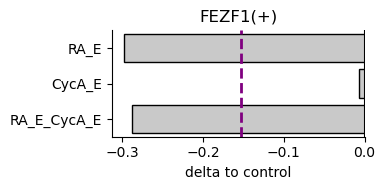

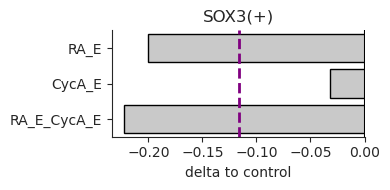

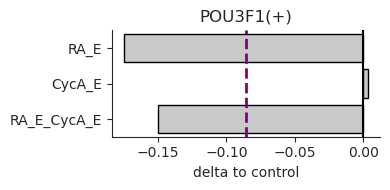

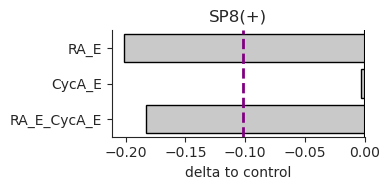

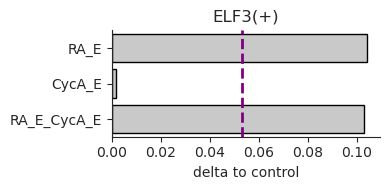

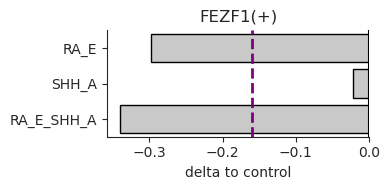

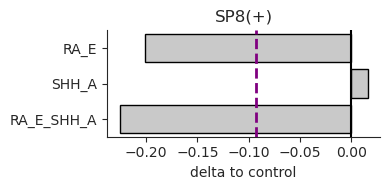

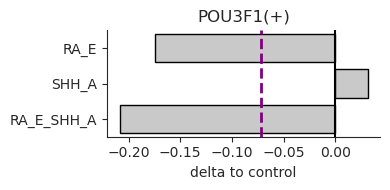

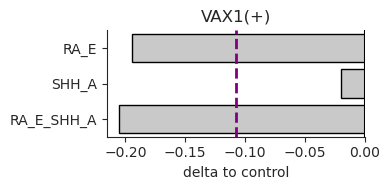

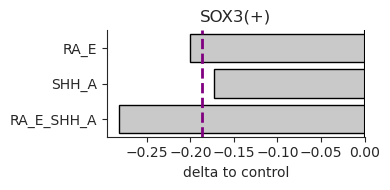

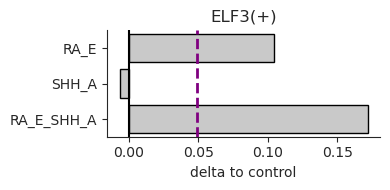

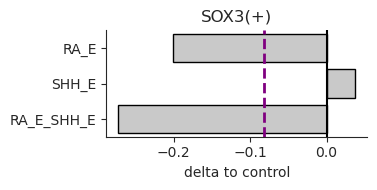

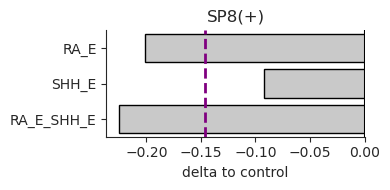

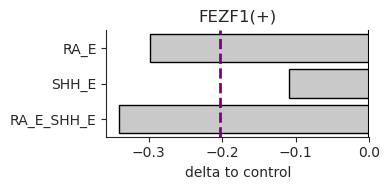

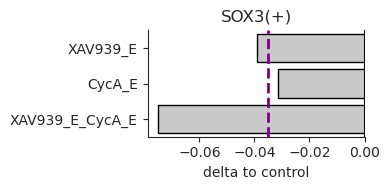

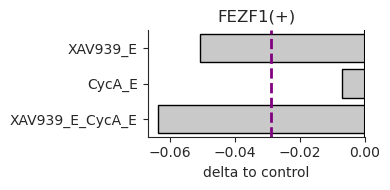

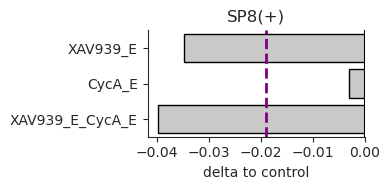

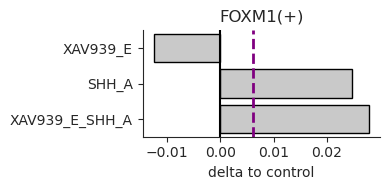

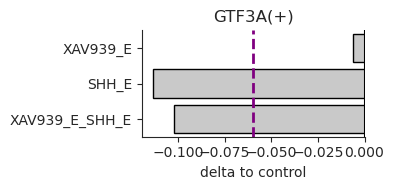

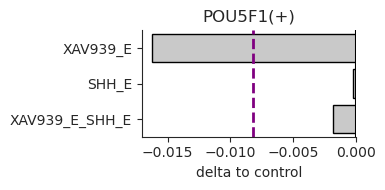

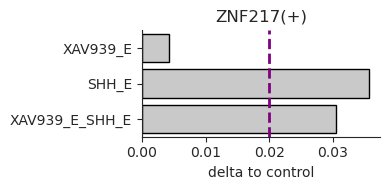

In [22]:

for index, row in final_epist.iterrows():
    df = plot_df.loc[row['Regulon'], [row.A, row.B, row.Condition, ]].T
    expected_val = auc.loc[row['Regulon'], 'expected_'+row.Condition]
    
    fig, ax = plt.subplots(figsize=(4, 2))

    sns.set_style("white")
    sns.set_style('ticks') 
    ax.spines[['right', 'top']].set_visible(False)
    
    sns.barplot(y=df.index, x=df,
        linewidth=1, edgecolor="black", facecolor='#C9C9C9')
    plt.axvline(x=expected_val,  color='purple', ls='--', lw=2)
    plt.axvline(x=0,  color='black')
    #plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('')
    #ax.set(xlim=(min(df), max(df)))
    plt.title(df.name)
    plt.xlabel('delta to control')
    
    plt.tight_layout()
    plt.rcParams['pdf.fonttype'] = 42 
    plt.savefig(path_fig+df.name +row.Condition+'.pdf', dpi=500, 
               format='pdf', bbox_inches='tight')
 

## baseline

In [23]:
inter  = adata[adata.obs.Experiment.isin(['OG1', 'OG2'])].copy()
auc = pd.DataFrame(inter.obsm['auc_from_HES3']).copy()
auc['Cell_Line_raw'] = inter.obs['Cell_Line_raw']
auc['Condition'] = inter.obs['Condition'].values.tolist().copy()
auc['Condition'] = auc['Condition'].replace({'Control_OG2': 'Control', 'Control_OG1': 'Control'})
auc = auc[auc['Condition'] == 'Control']
auc = pd.DataFrame(auc.groupby('Cell_Line_raw').mean())
auc = auc.T

/tmp/ipykernel_1229458/1059437016.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  auc = pd.DataFrame(auc.groupby('Cell_Line_raw').mean())


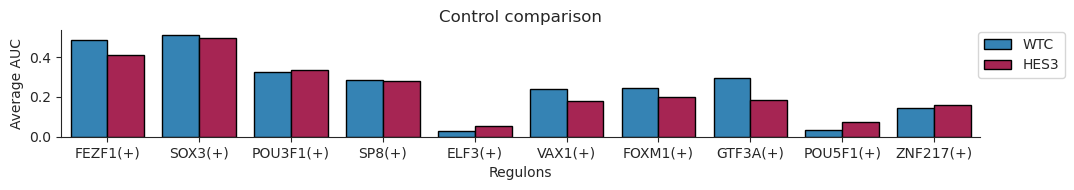

In [39]:
cols_Cell_Line = {"WTC":"#2088C9", "H9":"#FFC502", "WIBJ2":"#332288",
                  "H1":"#44AA99", "ESC":"lightgray","iPSC":"lightgray", "HES3":"#BC0F4D",
                 '?': 'lightgray'}
plot_df = auc.loc[final_epist.Regulon.unique().tolist()].copy()
plot_df = plot_df.reset_index()
plot_df = pd.melt(plot_df, id_vars='Regulon')


fig, ax = plt.subplots(figsize=(10, 2))

sns.set_style("white")
sns.set_style('ticks') 
ax.spines[['right', 'top']].set_visible(False)

sns.barplot(data = plot_df, y='value', x='Regulon', hue='Cell_Line_raw',
    linewidth=1, edgecolor="black", palette=cols_Cell_Line)
plt.xlabel('')
plt.ylabel('Average AUC')
plt.title('Control comparison')
plt.xlabel('Regulons')

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42 
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig(path_fig+'Control_comparison.pdf', dpi=500, 
               format='pdf', bbox_inches='tight')

# FGF-8, BMP4, BMP7

In [40]:
cont = pd.read_csv(Path(path_data)/'Ref_Controls.csv')

cont.head()

,Experiment,Control,Condition,Cell_Line,No_organoids
0,SMG1,Control_SMG1,Control_SMG1,HES3,12
1,SMG1,Control_SMG1,SHH_A,HES3,7
2,SMG1,Control_SMG1,SHH_B,HES3,8
3,SMG1,Control_SMG1,SHH_C,HES3,8
4,SMG1,Control_SMG1,SHH_D,HES3,8


In [48]:
common_cond = [
    'Control_FGF8',
 'FGF8_late_A',
 
 'FGF8_late_B',
 'FGF8_late_C',
'FGF8_late_D',
      'FGF8_late_E',         
'Control_BMP4',
 'BMP4_A',
'BMP4_B',
'BMP4_C',
 'BMP4_D',
'BMP4_E',
  'Control_BMP7',
  'BMP7_A', 
    'BMP7_B',
'BMP7_C',
    'BMP7_D',
'BMP7_E' ] 


In [44]:
cont[cont.Condition.isin(common_cond)].Control.unique()

array(['Control_SMG4_1', 'Control_SMG4_2', 'Control_SMOG1'], dtype=object)

In [51]:

control_dict = {'Control_SMG4_1' : 'Control_BMP4',
 'Control_SMG4_2' : 'Control_BMP7',
 'Control_SMOG1':'Control_FGF8'}

auc_df = adata.obsm['auc_from_HES3'].copy()
auc_df['Cell_Line_raw'] = adata.obs['Cell_Line_raw']
auc_df['Condition'] = adata.obs['Condition']
auc_df['Condition'] = auc_df['Condition'].replace(control_dict)

auc_df = auc_df[auc_df.Condition.isin(common_cond)]
auc_df['Condition'] = auc_df['Condition'].astype(str)


/tmp/ipykernel_1229458/2199170634.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 2))


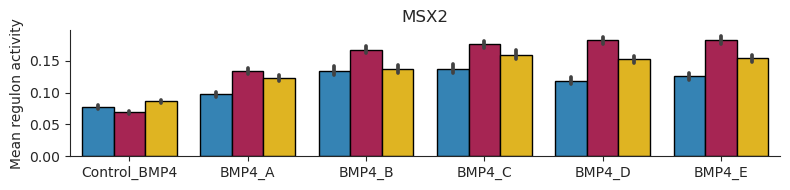

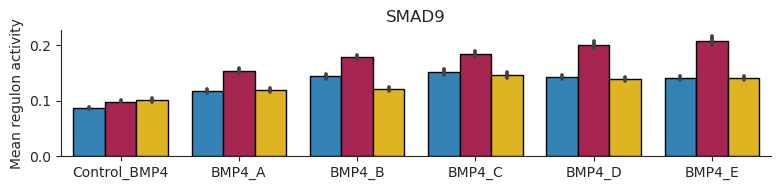

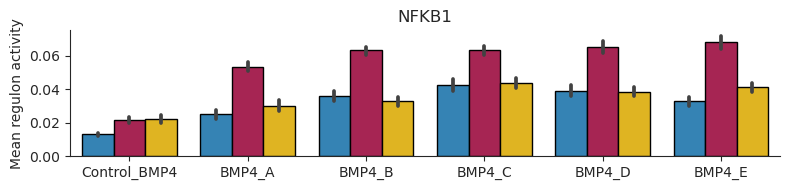

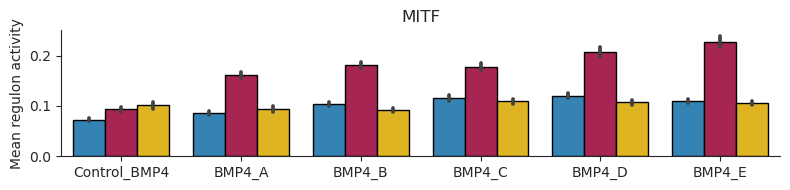

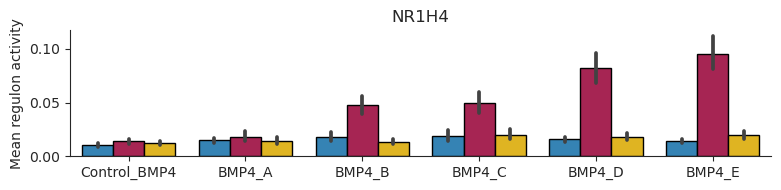

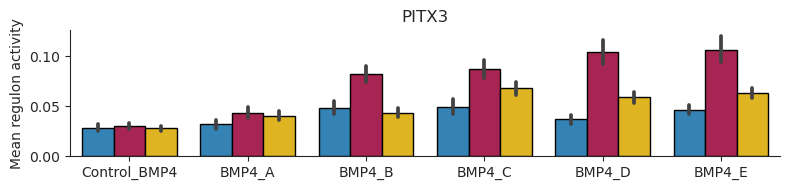

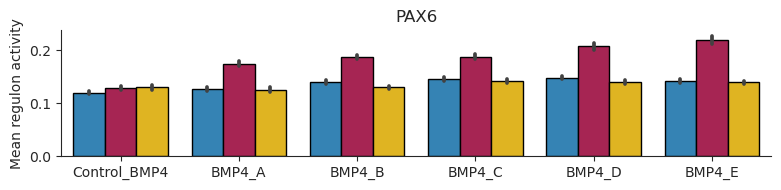

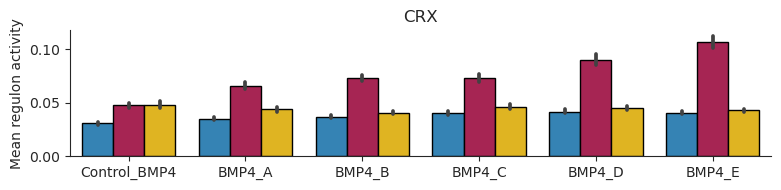

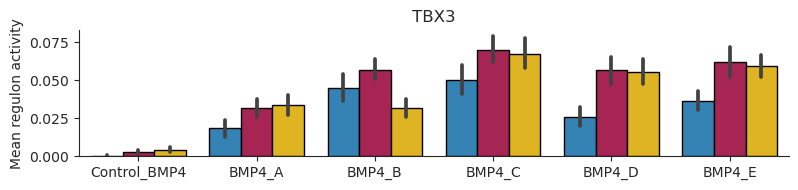

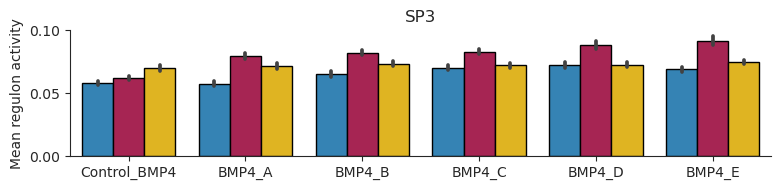

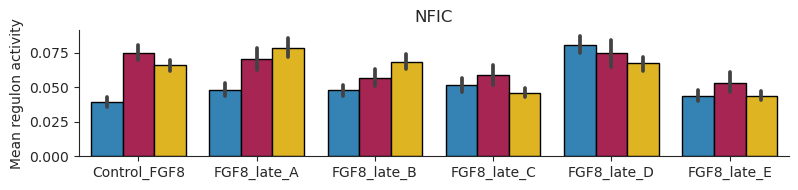

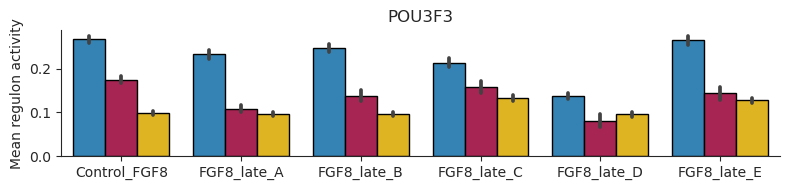

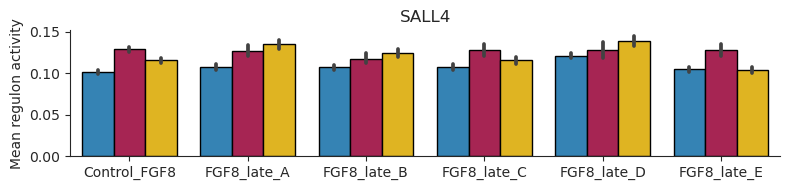

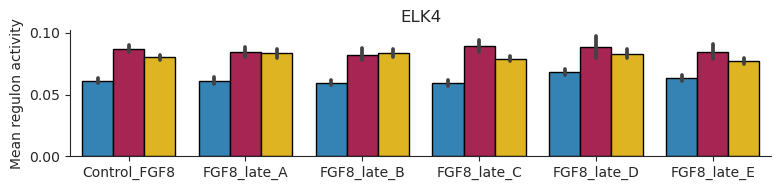

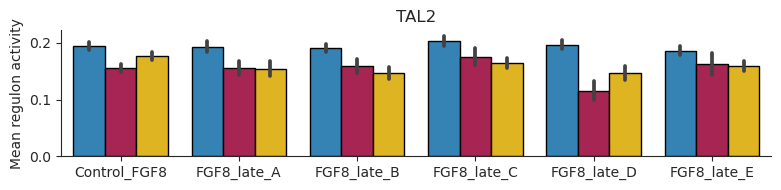

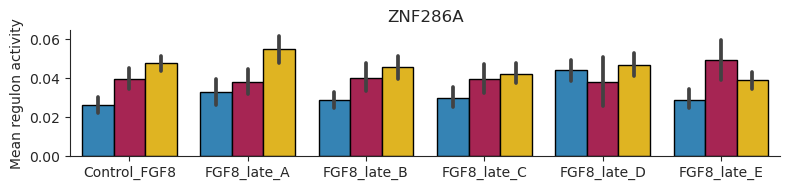

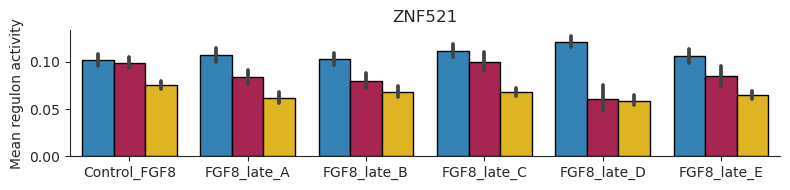

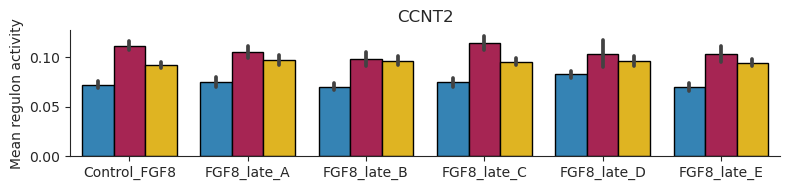

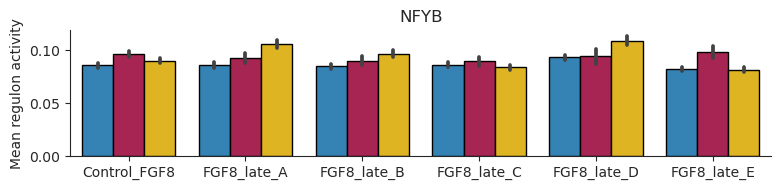

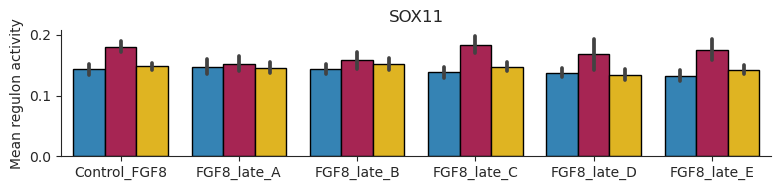

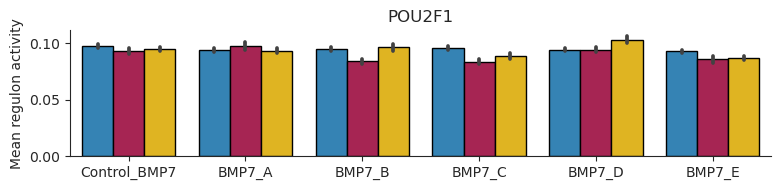

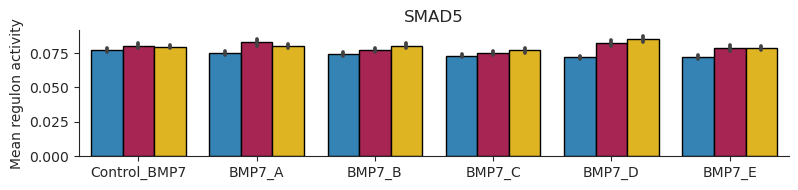

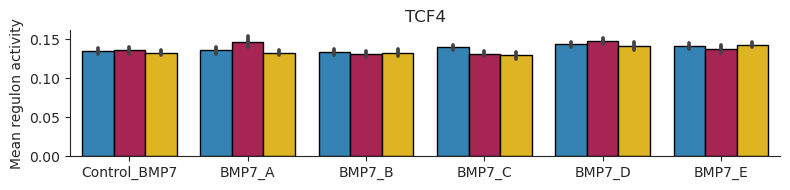

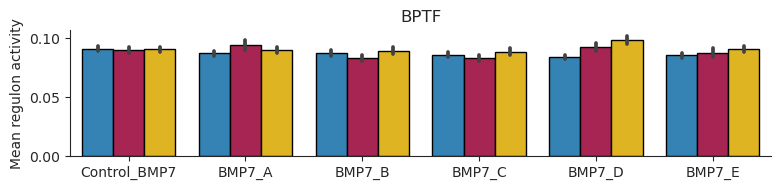

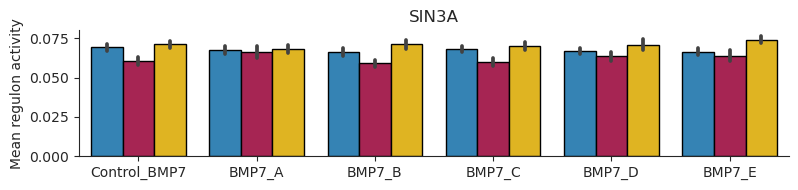

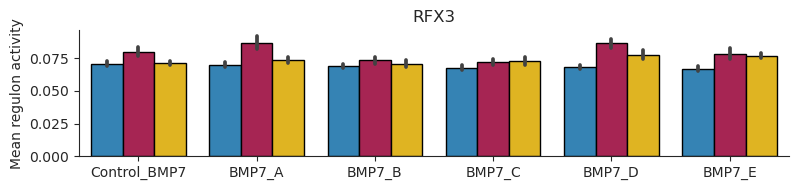

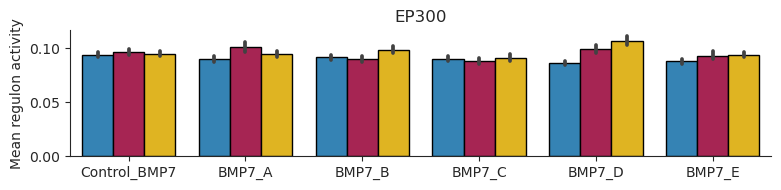

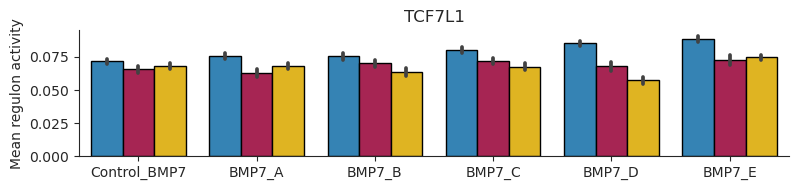

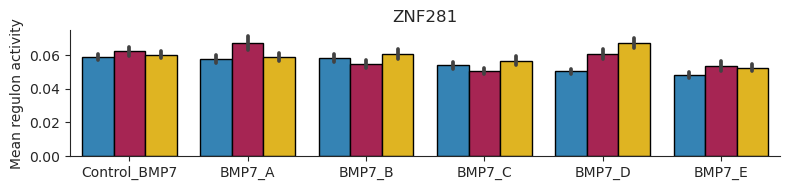

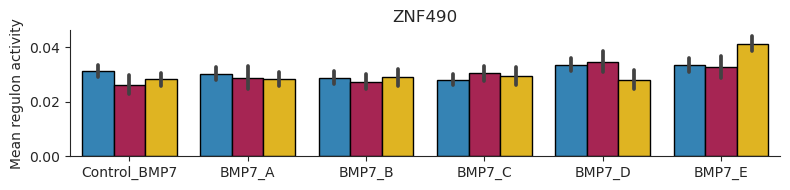

In [57]:
net1 = pd.read_csv(Path(path_data)/"HES3_module_summary_uniq_coded_filtered_wcomb_wcorr_sizes.tsv",
                 sep='\t')
net1.sort_values('w', ascending=False)

cols_Cell_Line = {"WTC":"#2088C9", "H9":"#FFC502", "WIBJ2":"#332288",
                  "H1":"#44AA99","HES3":"#BC0F4D"}

for elem in ['BMP4', 'FGF8','BMP7']:
    regulons = net1[net1.morph==elem].sort_values('w', ascending=False).iloc[:10,:]['gene'].tolist()
    cond_plot = [x for x in common_cond if elem in x ]
    auc_plot = auc_df[auc_df.Condition.isin(cond_plot)]

    
    for regulon in regulons:
        fig, ax = plt.subplots(figsize=(8, 2))
        sns.set_style("white")
        sns.set_style('ticks')
        ax.spines[['right', 'top']].set_visible(False)
        sns.barplot(x="Condition", hue="Cell_Line_raw", y=regulon, data=auc_plot,
                    order = cond_plot,
                   
        linewidth=1, edgecolor="black", palette=cols_Cell_Line)
        plt.xlabel('')
        plt.title(regulon[:-3])
        plt.ylabel('Mean regulon activity')
        ax.get_legend().set_visible(False)
        plt.tight_layout()
        plt.rcParams['pdf.fonttype'] = 42 
        plt.savefig(path_fig + elem + '_' + regulon + '.pdf', dpi=500, 
                   format='pdf', bbox_inches='tight')
            
